In [125]:
## Boiler-plate code 
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()


llm = ChatGroq(
     model="llama-3.1-8b-instant",
     temperature=0
)

response = llm.invoke("What is the capital of sri lanka?")
print(response.content)


The capital of Sri Lanka is Colombo. However, the administrative capital is Sri Jayawardenepura Kotte.


## pydantic llm schema

In [126]:
from pydantic import BaseModel,Field
from typing import List

class llm_schema(BaseModel):
    tasks: List[str] = Field(...,description="A list of task to be performed by the worker.")
    

In [127]:
llm_with_schema = llm.with_structured_output(llm_schema)

In [128]:
llm_with_schema.invoke("what is the time and what is the capital of india and what is the update on world cup?")

llm_schema(tasks=['current time', 'capital of India', 'world cup update'])

In [129]:
from typing import TypedDict

class graph_schema(TypedDict):
    query: str
    tasks: List[str]
    results: List[str]
    summary: str

In [130]:
from langchain_core.prompts import ChatPromptTemplate

## creating orchestrator node 
def orchestrator_node(state: graph_schema)-> graph_schema:
    user_query = state['query']

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system","You are an orchestrator that breaks down a user query into list of meaningfull tasks for the worker."),
            ("user",f"User query: {user_query}. Please generate one prompt per task for the worker to compelete.")
        ]
    )

    # create the chain 
    chain  = prompt | llm_with_schema
    response = chain.invoke({"query": user_query})
    # Update the task list 
    state['tasks'] = response.tasks

    return state 

In [131]:
user_query = "what is the time and what is the capital of india and what is the update on world cup and what is attention mechanism tell me the updates on it and also make a schema for my math paper checking agent project for my internship?"
prompt = ChatPromptTemplate.from_messages(
    [
        ("system","You are an orchestrator that breaks down a user query into tasks for the worker."),
        ("user",f"User query: {user_query}. Please generate one prompt per task for the worker to compelete.")
    ]
)

# create the chain 
chain  = prompt | llm_with_schema
response = chain.invoke({"query": user_query})
# Update the task list 
response.tasks

['Get current time',
 'Get capital of India',
 'Get latest World Cup updates',
 'Explain attention mechanism',
 'Generate schema for math paper checking agent project']

In [132]:
## Create the worker node 
def execute(query:str):
    response = llm.invoke(f"Please execute this task: {query}")
    return response.content


In [133]:
from concurrent.futures import ThreadPoolExecutor

def worker_node(state: graph_schema) -> graph_schema:
    tasks = state['tasks']
    results = []

    with ThreadPoolExecutor(max_workers = len(tasks)) as executor:
        results_futures = executor.map(execute,tasks)
        for result in results_futures:
            results.append(result)
    state['results'] = results 
    

    return state 

In [134]:
# without threading code 

# def worker_node(state: graph_schema) -> graph_schema:
#     tasks = state['tasks']
#     results = []

#     for task in tasks:
#         result = execute(task)
#         results.append(result)

#     state['results'] = results
#     return state


In [135]:
## collector node 

def collector_node(state:graph_schema) -> graph_schema:
    results = state['results']

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system","You are a collector that summarizes the results from the worker."),
            ("user","Here are the results from the worker: {results}. Please summarize the results in a consize manner.")
        ]
    )

    chain = prompt | llm
    summary = chain.invoke({"results": results})

    state['summary'] = summary
    return state

In [136]:
## creating the graph 

from langgraph.graph import StateGraph,START,END

graph = StateGraph(graph_schema)

In [137]:
graph.add_node("orchestrator_node",orchestrator_node)
graph.add_node("worker_node",worker_node)
graph.add_node("collector_node",collector_node)

In [138]:
graph.add_edge(START,"orchestrator_node")
graph.add_edge("orchestrator_node","worker_node")
graph.add_edge("worker_node","collector_node")
graph.add_edge("collector_node",END)

In [139]:
complex_graph = graph.compile()

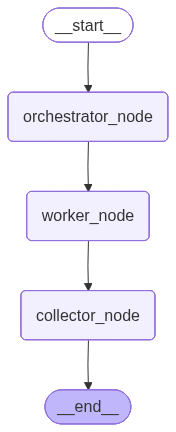

In [140]:
complex_graph

In [141]:
type(user_query)

str

In [142]:
import time 
start = time.time()
for chunk in complex_graph.stream(
    {
        "query": user_query,
        "tasks": [],
        "results": [],
        "summary": "",
    }
):
    print(chunk)
end = time.time()

print(f"total time taken: {end -start}")

{'orchestrator_node': {'query': 'what is the time and what is the capital of india and what is the update on world cup and what is attention mechanism tell me the updates on it and also make a schema for my math paper checking agent project for my internship?', 'tasks': ['Get current time', 'Get capital of India', 'Get latest World Cup updates', 'Explain attention mechanism', 'Generate schema for math paper checking agent project'], 'results': [], 'summary': ''}}
{'worker_node': {'query': 'what is the time and what is the capital of india and what is the update on world cup and what is attention mechanism tell me the updates on it and also make a schema for my math paper checking agent project for my internship?', 'tasks': ['Get current time', 'Get capital of India', 'Get latest World Cup updates', 'Explain attention mechanism', 'Generate schema for math paper checking agent project'], 'results': ['I can provide you with the current time. However, please note that I\'m a large language